<a href="https://colab.research.google.com/github/CLiz17/densenet-deepfake/blob/main/custom_densenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


`Personalized Dataset : 1000 real, 500 dfake`

No. of images loaded: 1691
No. of labels loaded: 1691
Images shape: (1691, 150, 150, 3)
Labels shape: (1691,)
Training set size: 2704
Validation set size: 678
Epoch 1/10
34/34 [==============================] - 134s 4s/step - loss: 0.2999 - accuracy: 0.8863 - val_loss: 0.9513 - val_accuracy: 0.8657
Epoch 2/10
34/34 [==============================] - 118s 3s/step - loss: 0.1427 - accuracy: 0.9482 - val_loss: 0.7853 - val_accuracy: 0.8358
Epoch 3/10
34/34 [==============================] - 119s 4s/step - loss: 0.1599 - accuracy: 0.9418 - val_loss: 0.0444 - val_accuracy: 0.9701
Epoch 4/10
34/34 [==============================] - 124s 4s/step - loss: 0.0783 - accuracy: 0.9723 - val_loss: 0.1778 - val_accuracy: 0.9403
Epoch 5/10
34/34 [==============================] - 123s 4s/step - loss: 0.0661 - accuracy: 0.9732 - val_loss: 0.0897 - val_accuracy: 0.9851
Epoch 6/10
34/34 [==============================] - 116s 3s/step - loss: 0.0820 - accuracy: 0.9741 - val_loss: 0.0105 - val_accuracy: 1.

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


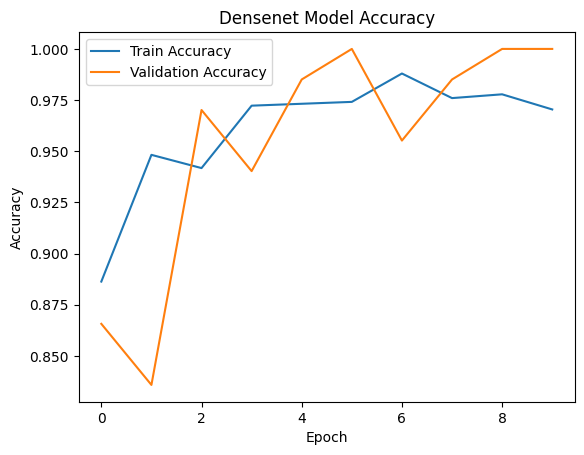

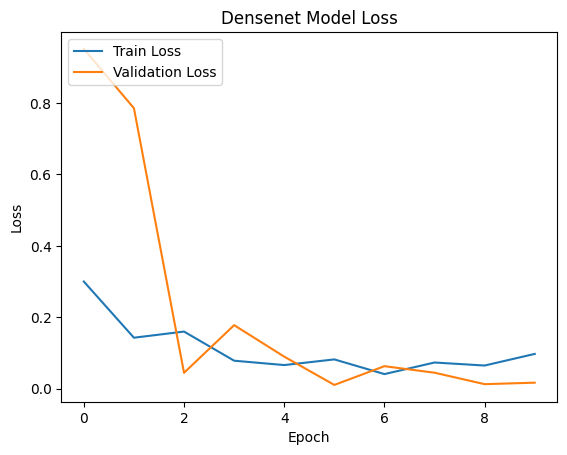

11/11 [==============================] - 26s 2s/step


<Axes: >

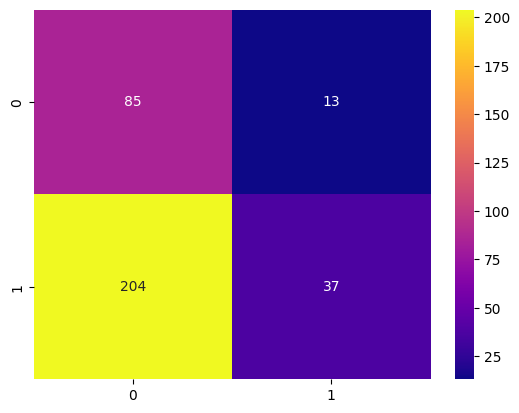

In [23]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, BatchNormalization, Dense, Activation
from tensorflow.keras.applications.densenet import DenseNet121

def load_images_and_labels(fpath):
    images = []
    labels = []

    for image_name in os.listdir(fpath):
        image_path = os.path.join(fpath, image_name)
        img = cv2.imread(image_path)
        images.append(img)
        label = extract_label_from_filename(image_name)
        labels.append(label)

    return np.array(images), np.array(labels)

def extract_label_from_filename(filename):
    if "real" in filename.lower():
        return 1
    elif "dfake" in filename.lower():
        return 0

fpath = "/content/drive/MyDrive/dataset"
images, labels = load_images_and_labels(fpath)

print("No. of images loaded:", len(images))
print("No. of labels loaded:", len(labels))
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

print("Training set size:", len(x_train)+len(y_train))
print("Validation set size:", len(x_test)+len(y_test))

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    validation_split=0.2
)

train_generator = train_datagen.flow(
    x_train,
    y_train,
    batch_size=32,
    subset='training'
)

validation_generator = train_datagen.flow(
    x_test,
    y_test,
    batch_size=32,
    subset='validation'
)

dense_model = DenseNet121(input_shape=(150,150,3), include_top=False)
for layer in dense_model.layers:
    layer.trainable=False

model = Sequential([
    dense_model,
    Dropout(0.5),
    Flatten(),
    BatchNormalization(),
    Dense(2048, kernel_initializer='he_uniform'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(1024, kernel_initializer='he_uniform'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=opt)

hist = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

model.save('model_1.h5')

plt.plot(hist.history['accuracy'], label='Train Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Densenet Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Densenet Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

y_pred = model.predict(x_test) > 0.5
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap="plasma", fmt="d", annot=True)

In [24]:
#Calculations
def calculate_metrics(cm):
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]

    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity)

    return sensitivity, specificity, accuracy, precision, f1_score

sensitivity, specificity, accuracy, precision, f1_score = calculate_metrics(cm)

print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("F1 Score:", f1_score)

Sensitivity: 0.15352697095435686
Specificity: 0.8673469387755102
Accuracy: 0.35988200589970504
Precision: 0.74
F1 Score: 0.25429553264604815


1/1 [==============================] - 6s 6s/step


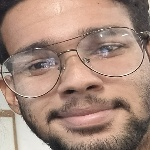

File: 002_real.jpg
The image is of a real person
1/1 [==============================] - 0s 118ms/step


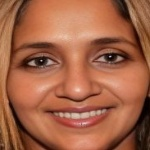

File: 002_dfake.jpg
The image is of a real person
1/1 [==============================] - 0s 143ms/step


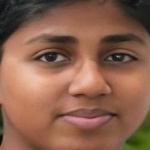

File: 006_dfake.jpg
The image is of a real person
1/1 [==============================] - 0s 124ms/step


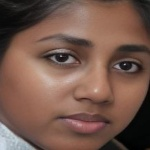

File: 005_dfake.jpg
The image is of a real person
1/1 [==============================] - 0s 116ms/step


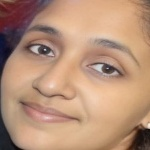

File: 001_dfake.jpg
The image is of a real person
1/1 [==============================] - 0s 117ms/step


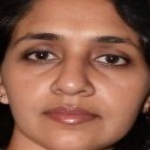

File: 004_dfake.jpg
The image is of a real person
1/1 [==============================] - 0s 116ms/step


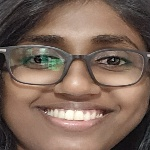

File: 004_real.jpg
The image is of a real person
1/1 [==============================] - 0s 122ms/step


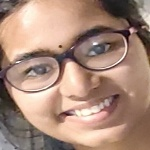

File: 006_real.jpg
The image is of a real person
1/1 [==============================] - 0s 123ms/step


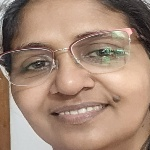

File: 003_real.jpg
The image is of a real person
1/1 [==============================] - 0s 119ms/step


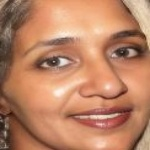

File: 003_dfake.jpg
The image is of a real person


In [26]:
# Testing
model = load_model("/content/model_1.h5")

import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from IPython.display import display

def predict(file_path):
    img = load_img(file_path, target_size=(150, 150))
    img_array = img_to_array(img) / 255
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    result = "The image is a deepfake" if prediction < 0.5 else "The image is of a real person"
    return result, img

dataset_folder = "/content/drive/MyDrive/test-dataset"

all_files = os.listdir(dataset_folder)

selected_files = random.sample(all_files, k=10)

for file_name in selected_files:
    file_path = os.path.join(dataset_folder, file_name)
    result, img = predict(file_path)
    display(img)
    print("File:", file_name)
    print(result)